In [1]:
from pyNN.random import RandomDistribution, NumpyRNG
from pyNN import neuron
import pyNN.space as space
import pyNN
import pyNN.neuron as sim
import numpy as np
from pyNN.utility.plotting import Figure, Panel
from pyNN.space import Grid2D, RandomStructure, Sphere
import matplotlib.pyplot as plt
from neuroml import Morphology, Segment, Point3DWithDiam as P
from pyNN.morphology import NeuroMLMorphology, NeuriteDistribution, Morphology as Morph, IonChannelDistribution
from pyNN.neuron.morphology import uniform, random_section, random_placement, at_distances, apical_dendrites, dendrites, centre
from pyNN.parameters import IonicSpecies
from pyNN.standardmodels import StandardIonChannelModel, build_translations
from pyNN.neuron import NativeCellType
import shutil
import os
from neuron import h, nrn, hclass
from pyNN.utility.build import compile_nmodl
from pyNN.standardmodels.cells import MultiCompartmentNeuron as mc
import platform

c:\Users\BMClab\Modelo-Motoneuronio\modelpynn\lib\site-packages\pyNN\neuron\__init__.py:14: UserWarning: mpi4py not available
  warnings.warn("mpi4py not available")


In [2]:
if platform.system() == 'Linux':
    shutil.copyfile('mn.mod','modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.mod')
    compile_nmodl('modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/')
    h.nrn_load_dll('modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.o')
if platform.system() == 'Windows':
    shutil.copyfile('mn.mod','modelpynn/Lib/site-packages/pyNN/neuron/nmodl/mn.mod')
    compile_nmodl('modelpynn/Lib/site-packages/pyNN/neuron/nmodl')
    h.nrn_load_dll('modelpynn/Lib/site-packages/pyNN/neuron/nmodl/mn.o')


nrnivmodl found at c:\nrn\bin\nrnivmodl
Successfully compiled NEURON extensions.


In [3]:
# input_rate = 100
# refractory_period = RandomDistribution('uniform', [2.0, 3.0], rng=NumpyRNG(seed=4242))
# v_init = RandomDistribution('uniform', (-70.0, -60.0))
# ctx_parameters = {
#     'cm': 0.25, 'tau_m': 20.0, 'v_rest': -60, 'v_thresh': -50, 'tau_refrac': refractory_period,
#     'v_reset': -60, 'v_spike': -50.0, 'a': 1.0, 'b': 0.005, 'tau_w': 600, 'delta_T': 2.5,
#     'tau_syn_E': 5.0, 'e_rev_E': 0.0, 'tau_syn_I': 10.0, 'e_rev_I': -80 }
# cortical_type = sim.EIF_cond_exp_isfa_ista(**ctx_parameters)

In [4]:
class KsChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": -80,
        "vt": -57.65
    }
    
    translations = build_translations(
        ('conductance_density', 'gk_slow'),
        ('e_rev', 'eks'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'p': ('motoneuron', 'p'),
    }
    default_initial_values = {
        'p': 1,  # initial value for gating variable m
    }
    units = {
        'iks': 'mA/cm2',
        'p': 'dimensionless',
    }
    recordable = ['iks','p']
    model = "motoneuron"
    conductance_density_parameter = 'gk_slow'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [5]:
class KfChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": -80,
        "vt": -57.65
    }
    
    recordable = ['ikf','n'] 
    translations = build_translations(
        ('conductance_density', 'gk_fast'),
        ('e_rev', 'ekf'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'n': ('motoneuron', 'n'),
    }
    default_initial_values = {
        'n': 1,  # initial value for gating variable m
    }
    units = {
        'ikf': 'mA/cm2',
        'n': 'dimensionless',
    }
    model = "motoneuron"
    conductance_density_parameter = 'gk_fast'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [6]:
class NaChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": 50,
        "vt":-57.65,
    }
    
    default_initial_values = {
        'm': 1.0,  # initial value for gating variable m
        'h': 0.0,  # initial value for gating variable h
    }
    recordable = ['ina', 'm', 'h']
    units = {
        'ina': 'mA/cm2',
        'm': 'dimensionless',
        'h': 'dimensionless',
    }
    translations = build_translations(
        ('conductance_density', 'gna'),
        ('e_rev', 'ena'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'h': ('motoneuron', 'h'),
        'm': ('motoneuron', 'm'),
        'ina': ('motoneuron', 'ina'),
    }
    model = "motoneuron"
    conductance_density_parameter = 'gna'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [7]:
class PassiveLeak(StandardIonChannelModel):
    translations = build_translations(
        ('conductance_density', 'gl'),
        ('e_rev', 'el'),
    )
    variable_translations = {}
    model = "motoneuron"
    conductance_density_parameter = 'gl'

In [8]:
soma1 = Segment(proximal=P(x=77.5, y=0, z=0, diameter=77.5),
               distal=P(x=0, y=0, z=0, diameter=77.5),
               name="soma", id=0)
soma2 = Segment(proximal=P(x=82.5, y=0, z=0, diameter=82.5),
               distal=P(x=0, y=0, z=0, diameter=82.5),
               name="soma", id=0)
dend1 = Segment(proximal=P(x=0, y=0, z=0, diameter=41.5),
               distal=P(x=-5500, y=0, z=0, diameter=41.5),
               name="dendrite",
               parent=soma1, id=1)
dend2 = Segment(proximal=P(x=0, y=0, z=0, diameter=62.5),
               distal=P(x=-6789, y=0, z=0, diameter=62.5),
               name="dendrite",
               parent=soma2, id=1)

class cell_class(sim.MultiCompartmentNeuron):


    def __init__(self, **parameters):

        self.label = "mn1"
        self.ion_channels = {'pas_soma': PassiveLeak, 'pas_dend': sim.PassiveLeak,
                           'na': NaChannel, 'kf': KfChannel, 'ks': KsChannel}
        self.units = {'v':'mV',
                      'gsyn_exc': 'uS',
                      'gsyn_inh': 'uS',
                      'na.m': 'dimensionless', 'na.h': 'dimensionless', 'kf.n': 'dimensionless', 'ks.p': 'dimensionless',
                      'na.ina': 'mA/cm2', 'kf.ikf': 'mA/cm2', 'ks.iks': 'mA/cm2'}
        self.post_synaptic_entities = {'AMPA': sim.CondExpPostSynapticResponse}
        print('10', parameters)
        super(cell_class, self).__init__(**parameters)
    
   


In [9]:
cell_type = cell_class(
    morphology=[NeuroMLMorphology(Morphology(segments=(soma1, 
                                                       dend1))),
                NeuroMLMorphology(Morphology(segments=(soma2, 
                                                       dend2)))],
    cm=1,    # mF / cm**2
    Ra=70
    ,  # ohm.cm
    ionic_species={"na": IonicSpecies("na", reversal_potential=50),
                   "ks": IonicSpecies("ks", reversal_potential=-80),
                   "kf": IonicSpecies("kf", reversal_potential=-80)
                  },
    pas_soma = {"conductance_density": uniform('soma', 7e-4), "e_rev":-70},
    pas_dend = {"conductance_density": uniform('dendrite', 7e-4), "e_rev":-70},
    na = {"conductance_density": uniform('soma', 30), "vt":[-57.65, -53]},
    kf = {"conductance_density": uniform('soma', 4), "vt":[-57.65, -53]},
    ks = {"conductance_density": uniform('soma', 1), "vt":[-57.65, -53]},

    AMPA={
        "locations": centre('dendrite'),  # number per µm
        "e_syn": 120,
        "tau_syn": 0.6
    },  
)

10 {'morphology': [<pyNN.morphology.NeuroMLMorphology object at 0x0000023024DCA650>, <pyNN.morphology.NeuroMLMorphology object at 0x0000023024DCA8F0>], 'cm': 1, 'Ra': 70, 'ionic_species': {'na': <pyNN.parameters.IonicSpecies object at 0x0000023024DCA170>, 'ks': <pyNN.parameters.IonicSpecies object at 0x0000023024DCBE20>, 'kf': <pyNN.parameters.IonicSpecies object at 0x0000023024DCBD90>}, 'pas_soma': {'conductance_density': <pyNN.neuron.morphology.uniform object at 0x0000023024DCBDF0>, 'e_rev': -70}, 'pas_dend': {'conductance_density': <pyNN.neuron.morphology.uniform object at 0x0000023024DCBBB0>, 'e_rev': -70}, 'na': {'conductance_density': <pyNN.neuron.morphology.uniform object at 0x0000023024DC9B40>, 'vt': [-57.65, -53]}, 'kf': {'conductance_density': <pyNN.neuron.morphology.uniform object at 0x0000023024DC9D20>, 'vt': [-57.65, -53]}, 'ks': {'conductance_density': <pyNN.neuron.morphology.uniform object at 0x0000023024DC9B70>, 'vt': [-57.65, -53]}, 'AMPA': {'locations': <pyNN.neuron.m

In [10]:
cells = sim.Population(2, cell_type, initial_values={'v': [-70, -70]})

In [11]:
cells[0]._cell.synaptic_receptors

{'AMPA': defaultdict(list, {1: [ExpSyn[0]]})}

In [12]:
def generate_spike_times(i):
    input_rate = 83
    number = int(2 * 100 * input_rate / 1000.0)
    gen = lambda: sim.Sequence(np.add.accumulate(np.random.exponential(1000.0 / input_rate, size=number)))
    if hasattr(i, "__len__"):
        return [gen() for j in i]
    else:
        return gen()
assert generate_spike_times(0).max() > 100

In [13]:
generate_spike_times([0,1])

[Sequence([  8.91461951  13.89349706  27.31086891  48.60275702  51.32358466
   53.20570463  55.35476082  60.15742954 107.96077421 108.17077956
  118.23188452 126.86177959 129.52088142 135.8541775  144.23990807
  145.33078361]),
 Sequence([ 15.28349334  18.7750915   40.35881551  53.66878782  65.33100299
   65.51789881  68.24838733  68.3058235   82.68094948  84.47077307
  127.70609338 132.63204027 153.91600567 154.59330726 162.08152449
  163.28381067])]

In [14]:


np.random.seed(26278342)
spike_source = sim.Population(400, sim.SpikeSourceArray(spike_times=generate_spike_times))
step_current_dend = sim.DCSource(amplitude=700, start=0, stop=50)
#step_current.inject_into(cells[1:2], location=apical_dendrites(fraction_along=0.9))
#step_current.inject_into(cells[1:2], location=random(after_branch_point(3)(apical_dendrites))
random_location = random_placement('dendrite')
# step_current_dend.inject_into(cells[0:2], location='dendrite')

In [15]:
spike_source.record('spikes')
cells.record('spikes')
cells[0:2].record('v', locations=('dendrite','soma'))
cells[0:2].record(('na.m', 'na.h'), locations='soma')
cells[0:2].record(('kf.n'), locations='soma')
cells[0:2].record(('ks.p'), locations='soma')


In [16]:
syn = sim.StaticSynapse(weight=600000000, delay=0.2)
input_conns = sim.Projection(spike_source, cells, 
                             sim.FixedProbabilityConnector(0.9, location_selector='dendrite'), syn, 
                             receptor_type="AMPA")


In [17]:
sim.run(100)

100.00000000001417

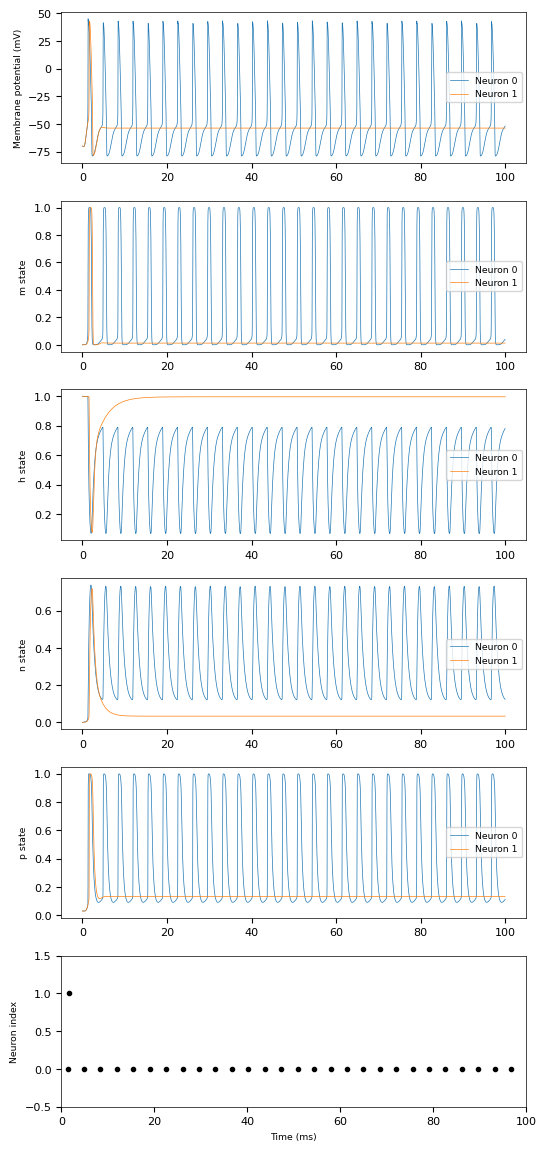

In [18]:
figure_filename = 'teste.png'

data = cells.get_data().segments[0]
vm = data.filter(name="soma.v")[0]
m = data.filter(name="soma.na.m")[0]
h = data.filter(name="soma.na.h")[0]
n = data.filter(name="soma.kf.n")[0]
p = data.filter(name="soma.ks.p")[0]
# ina = data.filter(name="soma.na.ina")[0]
# ik = data.filter(name="ik")[0]

# gsyn = data.filter(name="gsyn_exc")[0]
Figure(
    Panel(vm, ylabel="Membrane potential (mV)", xticks=True, yticks=True),
    Panel(m, ylabel="m state", xticks=True, yticks=True),
    Panel(h, ylabel="h state", xticks=True, yticks=True),
    Panel(n, ylabel="n state", xticks=True, yticks=True),
    Panel(p, ylabel="p state", xticks=True, yticks=True),
    # Panel(ina, ylabel="i_na (mA)", xticks=True, yticks=True),
    # Panel(ik, ylabel="i_k (mA)", xticks=True, yticks=True),
    
    # Panel(gsyn, ylabel="Synaptic conductance (uS)"),
    Panel(data.spiketrains, xlabel="Time (ms)", xticks=True, yticks=True),
).save(figure_filename)


In [19]:
data

Segment with [<AnalogSignal(array([[-70.        , -70.        ],
       [-70.09922778, -70.07646407],
       [-70.16376352, -70.12051697],
       ...,
       [-52.32830631, -53.77437075],
       [-52.13995418, -53.77437075],
       [-51.93012534, -53.77437075]]) * mV, [0.0 ms, 100.025 ms], sampling rate: 40.0 1/ms)>, <AnalogSignal(array([[0.02931223, 0.02931223],
       [0.02930129, 0.0293038 ],
       [0.02928367, 0.02929084],
       ...,
       [0.10938677, 0.13268353],
       [0.11039065, 0.13268353],
       [0.11143197, 0.13268353]]) * dimensionless, [0.0 ms, 100.025 ms], sampling rate: 40.0 1/ms)>, <AnalogSignal(array([[0.        , 0.        ],
       [0.00029447, 0.00010768],
       [0.00049424, 0.00017882],
       ...,
       [0.03793259, 0.01257833],
       [0.0390862 , 0.01257833],
       [0.04035192, 0.01257833]]) * dimensionless, [0.0 ms, 100.025 ms], sampling rate: 40.0 1/ms)>, <AnalogSignal(array([[0.00000000e+00, 0.00000000e+00],
       [9.00406027e-05, 4.15453134e-05],
 

In [20]:
A = 77.5*3.14*77.5+2*3.14*(77.5/2)**2
g = 1/1150
g/A

3.0738158628686215e-08

In [21]:
1/1000/14.4

6.944444444444444e-05